In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras.utils import pad_sequences
from torch.nn.utils.rnn import pad_sequence 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2024-05-27 14:06:40.406642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:06:41.033039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


cuda


## Funkcje pomocnicze

In [2]:
class LSTMRegressorFeatures(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size, num_features, max_length, hidden_layers=1, dropout=0.1, bidirectional=False):
        super(LSTMRegressorFeatures, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)

        self.fc_in = nn.Linear(num_features, hidden_size)
        self.layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.Dropout(dropout)
            ) for _ in range(hidden_layers)]
        )

        self.fc_out = nn.Linear(hidden_size * self.bidirectional * max_length + hidden_size, out_size)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def init_hidden(self, batch_size):
        # Inicjalizacja stanów ukrytych
        hidden = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers * self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden, features):
        x = x.transpose(0, 1)
        all_outputs, hidden = self.lstm(x, hidden)

        features = self.LeakyReLU(self.fc_in(features))
        for layer in self.layers:
            features = self.LeakyReLU(layer(features))

        all_outputs = all_outputs.transpose(0, 1)
        x = torch.cat((all_outputs.contiguous().view(all_outputs.size(0), -1), features), dim=1)
        x = self.fc_out(x)
        return x, hidden

In [ ]:
def train_lstm_features(model, train_loader, val_loader, optimizer, loss_fn, eval_fn, n_epochs=100, verbose=True, device='cuda'):
    if verbose:
        rng = tqdm(range(n_epochs))
    else:
        rng = range(n_epochs)

    loss_hist = []
    train_eval_hist = []
    val_eval_hist = []

    for epoch in rng:
        for x, features, targets, _, _, _ in train_loader:
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
            features = features.to(device)
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device) 
            preds, _ = model(x, (hidden,state), features)
            targets = targets.squeeze()
            targets = targets.type(torch.LongTensor).to(device)
            optimizer.zero_grad() 
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0 and verbose:
            print(f"Epoch: {epoch}, loss: {loss.item():.3}")

        loss_hist.append(loss.item())
        train_eval_hist.append(eval_fn(model, train_loader, device))
        val_eval_hist.append(eval_fn(model, val_loader, device))

    return loss_hist, train_eval_hist, val_eval_hist

In [ ]:
def pad_collate_feat(batch, pad_value=-1):
    xx, ff, yy = zip(*batch)

    x_lens = []
    for x in xx:
        try:
            x_lens.append(len(x))
        except:
            print(x)
            raise
    f_lens = [len(f) for f in ff]  
    y_lens = [1 for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    ff = torch.stack(ff)
    yy = torch.stack(yy)

    return xx_pad, ff, yy, x_lens, f_lens, y_lens

In [ ]:
def get_accuracy_features(net, data_loader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, f, y, _, _, _ in data_loader:
            x, f, y = x.to(device).unsqueeze(2), f.to(device), y.to(device)
            hidden, state = net.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = net(x, (hidden, state), f)
            _, predicted = torch.max(preds, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    net.train()
    return correct / total

In [ ]:
def get_confusion_matrix_features(net, data_loader, n_classes, device):
    net.eval()
    confusion_matrix = torch.zeros(n_classes, n_classes)
    with torch.no_grad():
        for x, f, y, _, _, _ in data_loader:
            x, f, y = x.to(device).unsqueeze(2), f.to(device), y.to(device)
            hidden, state = net.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
            preds, _ = net(x, (hidden, state), f)
            _, predicted = torch.max(preds, 1)
            for t, p in zip(y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    net.train()
    return confusion_matrix

In [ ]:
def plot_confusion_matrix(confusion_matrix, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    confusion_matrix = confusion_matrix.float() / confusion_matrix.sum(1).view(-1, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.size(0)):
        for j in range(confusion_matrix.size(1)):
            plt.text(j, i, format(confusion_matrix[i, j], ".2f"),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_training(loss, train_eval, valid_eval, ax=None):
    iters = np.arange(len(loss))
    if ax is None:
        fig, ax1 = plt.subplots()
    else:
        ax1 = ax

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(iters, loss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Evaluation', color=color)
    ax2.plot(iters, train_eval, color=color, linestyle='dashed', label='Train')
    ax2.plot(iters, valid_eval, color=color, linestyle='solid', label='Validation')
    ax2.tick_params(axis='y', labelcolor=color)

    if ax is None:
        fig.tight_layout()
        plt.legend()
        plt.show()

## Przekształcanie zbioru treningowego 

In [5]:
import optuna
from models import LSTMRegressorFeatures
from training_functions import train_lstm_features
from helper_functions import get_accuracy_features, plot_training, get_confusion_matrix_features, plot_confusion_matrix

In [6]:
def slicing(sequence: list):
    """Take a slice of the sequence."""
    try:
        start_idx = np.random.randint(0, len(sequence))
        end_idx = np.random.randint(start_idx, len(sequence))
        return sequence[start_idx:end_idx]
    except:
        return sequence

def random_erase(sequence: list, p=0.1):
    """Randomly erase some notes."""
    mask = np.random.choice([0, 1], size=len(sequence), p=[p, 1-p])
    return sequence * mask

def random_shift(sequence: list, max_shift=100):
    """Randomly shift the sequence."""
    shift = np.random.randint(-max_shift, max_shift)
    new_sequence = np.roll(sequence, shift)
    return new_sequence

In [7]:
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks

feature_names = ['mean', 'variance', 'standard_deviation', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast']

def add_features(seq):
    _data = np.array(seq)
    mean = np.mean(_data)
    variance = np.var(_data)
    standard_deviation = np.std(_data)
    fft_vals = fft(_data)
    fft_abs = np.abs(fft_vals)
    frequencies = np.linspace(0, len(_data), len(_data))
    spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)
    spectral_bandwidth = np.sum(fft_abs * ((frequencies - spectral_centroid) ** 2)) / np.sum(fft_abs)
    peaks, _ = find_peaks(fft_abs)
    valleys, _ = find_peaks(-fft_abs)
    spectral_contrast = np.mean(fft_abs[peaks]) - np.mean(fft_abs[valleys])
    return np.array([mean, variance, standard_deviation, spectral_centroid, spectral_bandwidth, spectral_contrast])

In [8]:
def feature_pipeline(data):
    from sklearn.preprocessing import MinMaxScaler

    feat_data = data.copy().reset_index(drop=True)
    feat_data['features'] = feat_data['sequence'].apply(add_features)
    for i, name in enumerate(feature_names):
        feat_data[name] = feat_data['features'].apply(lambda x: x[i])
    feat_data.drop(columns=['features'], inplace=True)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(feat_data[feature_names])
    y = feat_data['composer']

    ret = pd.DataFrame(X, columns=feature_names)
    ret['composer'] = y
    ret['sequence'] = feat_data['sequence']

    return ret

In [9]:
def augument_pipeline(data):
    funcs = [slicing, random_erase, random_shift]
    func_data = pd.DataFrame()
    for func in funcs:
        augmented_data = data.copy()
        augmented_data['sequence'] = augmented_data['sequence'].apply(lambda x: func(x))
        func_data = pd.concat([func_data, augmented_data])
    data = pd.concat([data, func_data])
    data.reset_index(drop=True, inplace=True)
    return data

In [10]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data.iloc[idx]['sequence'], dtype=torch.float32)
        feat_tensors = [torch.tensor(self.data.iloc[idx][name], dtype=torch.float32) for name in feature_names]
        features = torch.stack(feat_tensors)
        composer = torch.tensor(self.data.iloc[idx]['composer'], dtype=torch.float32)
        return seq, features, composer

In [11]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

data = pickle.load(open('train.pkl', 'rb'))
data = pd.DataFrame(data, columns=['sequence', 'composer'])
max_len = data['sequence'].apply(len).max()

X = pad_sequences(data['sequence'].tolist(), padding='post', maxlen=max_len)
y = np.array(data['composer'].tolist())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

train = pd.DataFrame({'sequence': X_train.tolist(), 'composer': y_train})
val = pd.DataFrame({'sequence': X_val.tolist(), 'composer': y_val})
test = pd.DataFrame({'sequence': X_test.tolist(), 'composer': y_test})

train, val = train_test_split(data, test_size=0.4, random_state=42, stratify=data['composer'])
val, test = train_test_split(val, test_size=0.5)
train = augument_pipeline(train)
train = train[train['sequence'].apply(len) > 0]
train = feature_pipeline(train)
val = feature_pipeline(val)
test = feature_pipeline(test)
train = train[~train.isna().any(axis=1)]
val = val[~val.isna().any(axis=1)]
test = test[~test.isna().any(axis=1)]
train = train[train['sequence'].apply(len) > 0]

train['sequence'] = train['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
val['sequence'] = val['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
test['sequence'] = test['sequence'].apply(lambda x: np.pad(x, (0, max_len - len(x)), 'constant', constant_values=-1))
display(train)

/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_29552/956652262.py:15: RuntimeWarning: invalid value encountered in scalar divide
  spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar

,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast,composer,sequence
0,0.444677,0.317075,0.563094,0.045947,0.002476,0.193110,4,"[32.0, 146.0, 33.0, 125.0, 92.0, 125.0, 159.0,..."
1,0.400071,0.398062,0.630921,0.029885,0.001019,0.217160,0,"[-1.0, -1.0, -1.0, 64.0, 145.0, 38.0, 78.0, 13..."
2,0.387255,0.243584,0.493542,0.009432,0.000120,0.104571,0,"[64.0, 64.0, 92.0, 159.0, 28.0, 47.0, 78.0, 64..."
3,0.320899,0.324415,0.569575,0.029945,0.001042,0.207526,0,"[0.0, 12.0, 12.0, 12.0, 124.0, 124.0, 15.0, 15..."
4,0.335351,0.326735,0.571608,0.083975,0.007946,0.236052,0,"[-1.0, -1.0, -1.0, -1.0, 88.0, 88.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...
6979,0.393011,0.362125,0.601769,0.027411,0.000773,0.154242,0,"[12.0, 148.0, 44.0, 44.0, 144.0, 144.0, 40.0, ..."
6980,0.314858,0.319165,0.564947,0.016596,0.000355,0.133863,0,"[92.0, 78.0, 71.0, 78.0, 28.0, 78.0, 156.0, 14..."
6981,0.319906,0.361161,0.600967,0.030166,0.001024,0.213702,0,"[13.0, 77.0, 152.0, 141.0, 12.0, 12.0, 125.0, ..."
6982,0.318283,0.309026,0.555901,0.054470,0.003216,0.190018,0,"[79.0, 159.0, 190.0, 15.0, 124.0, 79.0, 157.0,..."


In [13]:
from helper_functions import pad_collate_feat

train_dataset = FeatureDataset(train)
val_dataset = FeatureDataset(val)
test_dataset = FeatureDataset(test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate_feat)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_collate_feat)

## Eksperymenty na hiperparametrach

In [ ]:
def objective(trial):
    hidden_sizes = [16, 32, 64]
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 3)
    hidden_size = trial.suggest_categorical('hidden_size', hidden_sizes)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
    model = model.to(device)
    class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
    class_weights = 1 / class_counts.float()
    class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    try:
      _, _, _ = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=10, verbose=False, device=device)
      return get_accuracy_features(model, test_loader, device)
    except:
      return 0

In [ ]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=30, timeout=3600, n_jobs=1)

best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2024-05-26 22:47:05,277] A new study created in memory with name: no-name-55164789-5c69-4203-a344-90ba661bc52a
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20800909539898704 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-05-26 22:49:55,433] Trial 0 finished with value: 0.43197278911564624 and parameters: {'n_layers': 1, 'hidden_layers': 2, 'hidden_size': 16, 'dropout': 0.20800909539898704, 'lr': 0.00018165844561374346, 'bidirectional': True}. Best is trial 0 with value: 0.43197278911564624.
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects n

n_layers: 2
hidden_layers: 3
hidden_size: 64
dropout: 0.4174262352852624
lr: 0.0006275080621337554
bidirectional: True


/tmp/ipykernel_396643/2496925414.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


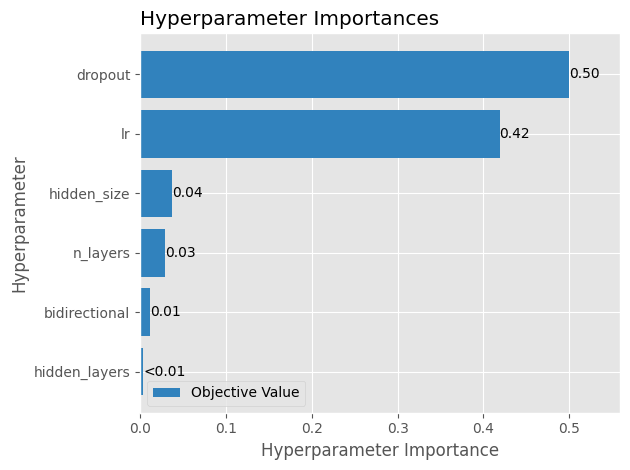

In [ ]:
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

/tmp/ipykernel_396643/2297176039.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study)
[W 2024-05-26 23:51:16,063] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


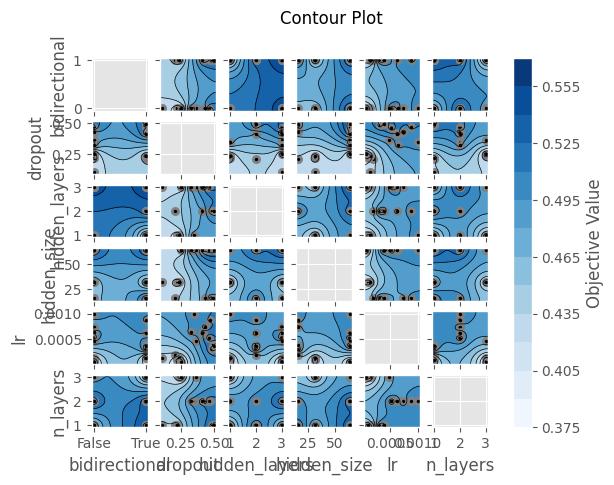

In [ ]:
fig = optuna.visualization.matplotlib.plot_contour(study)
plt.show()

## Finałowy model

In [17]:
dropout = 0.4
hidden_size = 64
n_layers = 2
hidden_layers = 3
lr = 0.0006
bidirectional = True

model = LSTMRegressorFeatures(input_size=1, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional, num_features=6, max_length=max_len, out_size=5, hidden_layers=hidden_layers)
model = model.to(device)
class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
class_weights = 1 / class_counts.float()
class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_hist, train_acc, val_acc = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, n_epochs=25, device=device)
final_accuracy = get_accuracy_features(model, test_loader, device)
print(f"Final accuracy: {final_accuracy}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0, loss: 1.24


 40%|████      | 10/25 [05:25<08:05, 32.34s/it]

Epoch: 10, loss: 0.156


 80%|████████  | 20/25 [10:55<02:45, 33.01s/it]

Epoch: 20, loss: 0.0584


100%|██████████| 25/25 [13:42<00:00, 32.91s/it]


Final accuracy: 0.6030664395229983


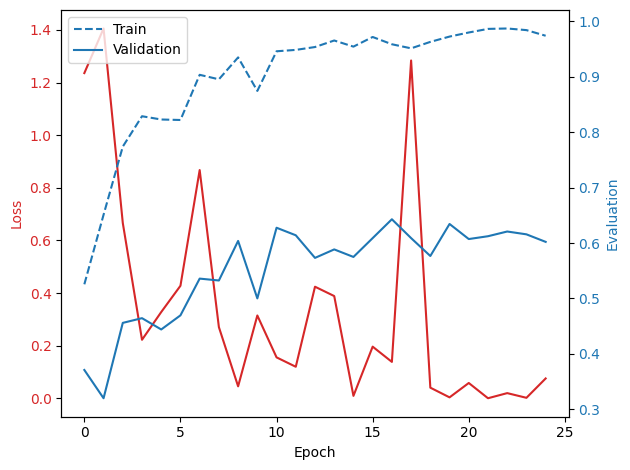

In [18]:
plot_training(loss_hist, train_acc, val_acc)

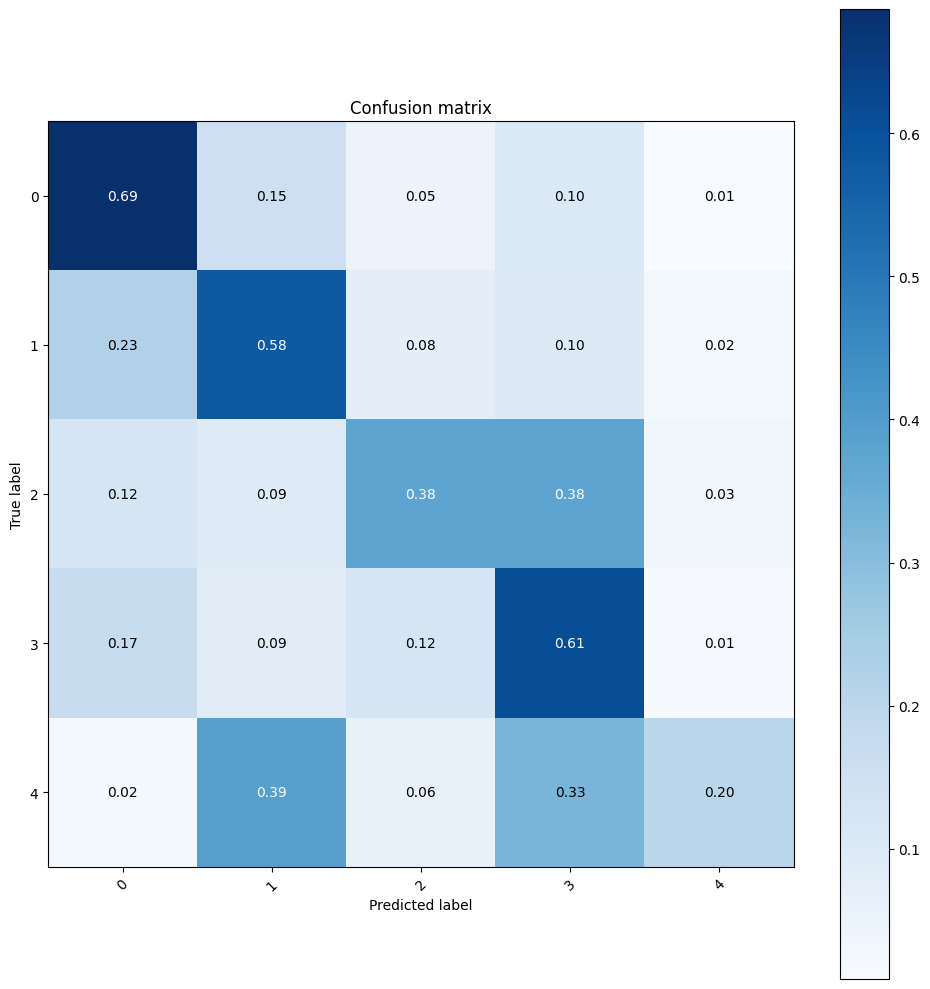

In [19]:
classes = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
cm = get_confusion_matrix_features(model, val_loader, 5, device)
plot_confusion_matrix(cm, classes)

In [20]:
torch.save(model.state_dict(), 'lstm_features_2.pth')